## 数据集探索性数据分析（Exploratory Data Analysis）

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import os

In [2]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

## 设置目录和标注的json文件

In [3]:
src_root = 'D:\\Dataset-Trash\\'
src_anno = 'VOCdevkit\\VOC2007\\Annotations\\'
src_image = 'VOCdevkit\\VOC2007\\JPEGImages\\'
src_file = 'trash_instances.json'
src_desc = 'trash_dataset' # a name (identifier) for the dataset

In [4]:
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

root.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

## 基本的高级别信息

In [5]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]




print('Dataset Name: ',src_desc)
print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Dataset Name:  trash_dataset
Number of images:  14964
Number of bounding boxes:  25590
Number of classes:  44
Max min avg height:  4160 76 580
Max min avg width:  4032 53 569


## 图像数据集中的目标分布

In [6]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

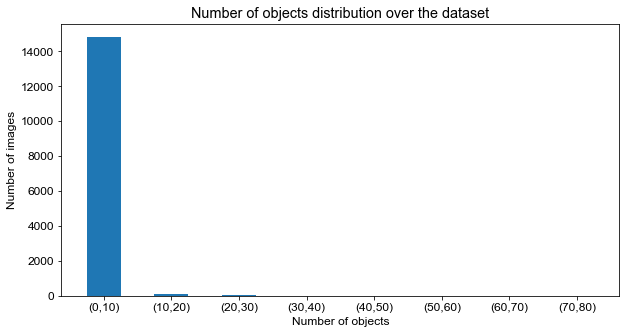

Number of images having atleast one box:  14964
Min number of boxes per image:  1
Max number of boxes per image:  79
Avg number of boxes per image:  1


In [7]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

## 目标的按类别分布情况

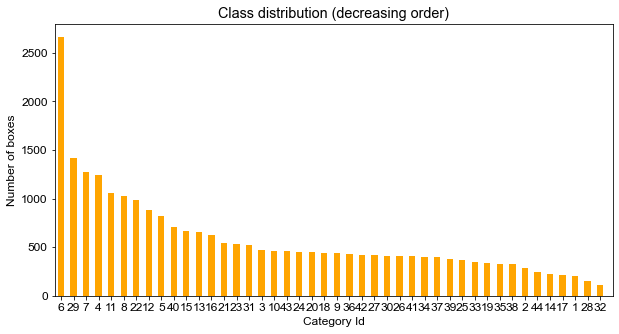

1 -> 书籍纸张, 2 -> 金属厨具, 3 -> 砧板, 4 -> 污损塑料, 5 -> 筷子, 6 -> 陶瓷器皿, 7 -> 插头电线, 8 -> 洗护用品, 9 -> 塑料玩具, 10 -> 鞋, 11 -> 果皮果肉, 12 -> 玻璃器皿, 13 -> 毛绒玩具, 14 -> 污损用纸, 15 -> 塑料器皿, 16 -> 纸盒纸箱, 17 -> 花盆, 18 -> 包, 19 -> 金属器皿, 20 -> 干电池, 21 -> 调料瓶, 22 -> 菜帮菜叶, 23 -> 锅, 24 -> 食用油桶, 25 -> 饮料瓶, 26 -> 充电宝, 27 -> 易拉罐, 28 -> 牙签, 29 -> 剩饭剩菜, 30 -> 大骨头, 31 -> 鱼骨, 32 -> 垃圾桶, 33 -> 酒瓶, 34 -> 金属食品罐, 35 -> 一次性快餐盒, 36 -> 烟蒂, 37 -> 旧衣服, 38 -> 塑料衣架, 39 -> 枕头, 40 -> 过期药物, 41 -> 茶叶渣, 42 -> 软膏, 43 -> 蛋壳, 44 -> 快递纸袋, 

In [8]:
# Class distribution
class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 44 classes
top = min(len(sorted_c2nb),44)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()



categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

## 边界框面积的按类别分布情况

In [9]:
# Class wise bounding box area distribution

bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in root['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

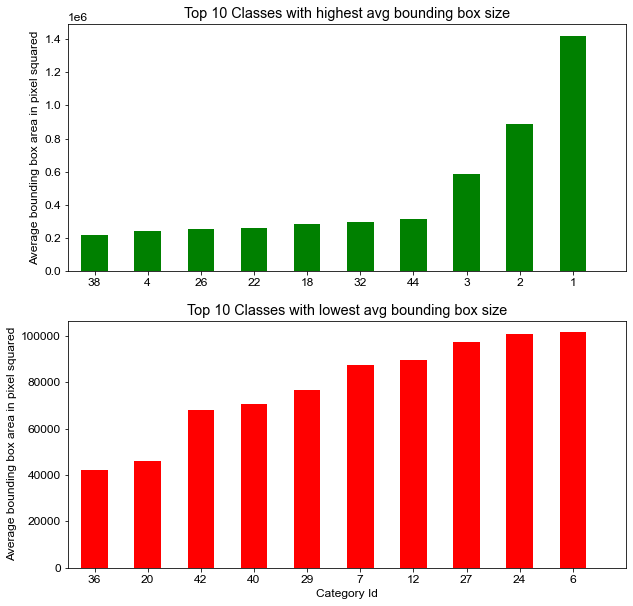

1 -> 书籍纸张, 2 -> 金属厨具, 3 -> 砧板, 4 -> 污损塑料, 5 -> 筷子, 6 -> 陶瓷器皿, 7 -> 插头电线, 8 -> 洗护用品, 9 -> 塑料玩具, 10 -> 鞋, 11 -> 果皮果肉, 12 -> 玻璃器皿, 13 -> 毛绒玩具, 14 -> 污损用纸, 15 -> 塑料器皿, 16 -> 纸盒纸箱, 17 -> 花盆, 18 -> 包, 19 -> 金属器皿, 20 -> 干电池, 21 -> 调料瓶, 22 -> 菜帮菜叶, 23 -> 锅, 24 -> 食用油桶, 25 -> 饮料瓶, 26 -> 充电宝, 27 -> 易拉罐, 28 -> 牙签, 29 -> 剩饭剩菜, 30 -> 大骨头, 31 -> 鱼骨, 32 -> 垃圾桶, 33 -> 酒瓶, 34 -> 金属食品罐, 35 -> 一次性快餐盒, 36 -> 烟蒂, 37 -> 旧衣服, 38 -> 塑料衣架, 39 -> 枕头, 40 -> 过期药物, 41 -> 茶叶渣, 42 -> 软膏, 43 -> 蛋壳, 44 -> 快递纸袋, 

In [10]:
top = min(10, len(bbox_avg_areas))

plt.figure(figsize=(10,10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]

y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with highest avg bounding box size')


plt.subplot(212)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='red')
plt.xlim(-0.5,len(y2))
plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with lowest avg bounding box size')
plt.show()

categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

## 随机显示图片和标签

[['食用油桶', 17, 26, 260, 390], ['食用油桶', 157, 1, 312, 267]]


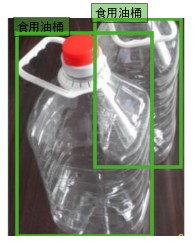

In [18]:
import xml.etree.ElementTree as ET
from matplotlib.patches import Rectangle # 再图像中绘制方框
import matplotlib.image as mpimg  # mpimg 用于读取图片
import random


# 测试图像的标注文件和图像
rand_id = random.randint(1, n_images) + 20210000000
xml_path = src_root + src_anno + str(rand_id)  + '.xml' #'VOC_image_demo/000002.xml'
img_path = src_root + src_image + str(rand_id)  + '.jpg' #'VOC_image_demo/000002.jpg'

bbox = []
tree = ET.parse(xml_path)
root = tree.getroot()
objects = root.findall('object')
for object in objects:
    # 根据找出的object再进一步找出图像中的类别名
    name = object.find('name').text
    # xml中的标记信息中的bndbox
    bndbox = object.find('bndbox')
    
    # 对应坐标
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    
    # 格式：类名:name+[坐标]
    bbox_i = [name,xmin,ymin,xmax,ymax]
    bbox.append(bbox_i)
 
print(bbox)

matplotlib.rcParams['font.family'] = 'SimHei'
image = mpimg.imread(img_path)  # 读取图片
# 显示原图
fig,ax = plt.subplots()
plt.imshow(image)
colors = dict()
for bbox_i in bbox:
    class_name = bbox_i[0]
    if class_name not in colors:
        # 随机生成颜色或者自己指定也可以
        colors[class_name] = (random.random(),random.random(),random.random())
    xmin = bbox_i[1]
    ymin = bbox_i[2]
    xmax = bbox_i[3]
    ymax = bbox_i[4]
    rect = Rectangle(xy=(xmin,ymin),width=xmax-xmin,
                     height=ymax-ymin,
                     edgecolor = colors[class_name],
                     facecolor = 'None',
                     linewidth = 3.5
                    )
    plt.text(xmin,ymin-6,'{:s}'.format(class_name),
            bbox = dict(facecolor=colors[class_name],
            alpha = 0.5))
    ax.add_patch(rect)
    plt.axis('off')